In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
path = 'hillary-clinton-emails/Emails.csv'
data = pd.read_csv(path, sep=',')

In [28]:
data.dropna(subset=['ExtractedBodyText'], inplace=True)
data.dropna(subset=['ExtractedSubject'], inplace=True)
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,token_Body,token_Subject
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,"Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,[thx],"[chris, stevens]"
5,6,C05739559,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Russorv@state.gov,H,80.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739559...,F-2015-04841,...,NaN,"Wednesday, September 12, 2012 01:00 PM",F-2015-04841,C05739559,05/13/2015,RELEASE IN PART,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,"[pis, print, h, fw, meet, right, wing, extremi...","[meet, right, wing, extremist, behind, anti, m..."
8,9,C05739562,SECRETARY'S REMARKS,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739562...,F-2015-04841,...,NaN,"Wednesday, September 12, 2012 6:08 PM",F-2015-04841,C05739562,05/13/2015,RELEASE IN FULL,FYI,UNCLASSIFIED\nU.S. Department of State\nCase N...,[],"[fvv, secretary, s, remarks]"
9,10,C05739563,MORE ON LIBYA,H,NaN,NaN,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739563...,F-2015-04841,...,NaN,NaN,F-2015-04841,C05739563,05/13/2015,RELEASE IN PART,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[libya, libya, sept, sending, direct, sent, ve...",[libya]
10,11,C05739564,ABZ AN HBJ ON LIBYA AND WEST BANK/GAZA,H,"Sullivan, Jacob J",87.0,2011-03-13T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739564...,F-2015-04841,...,NaN,"Sunday, March 13, 2011 10:55 AM",F-2015-04841,C05739564,05/13/2015,RELEASE IN PART,Fyi\nB6\n— —,UNCLASSIFIED\nU.S. Department of State\nCase N...,[],"[abz, libya, west, bank, gaza]"


In [4]:
def getRawText():
    subjectData = data[data.ExtractedSubject.notnull()].ExtractedSubject.astype(str)
    bodyData = data[data.ExtractedBodyText.notnull()].ExtractedBodyText.astype(str)
    rawText = ' '.join(subjectData) + ' ' + ' '.join(bodyData)
    rawText = rawText.replace('\n', ' ')
    return rawText

## 1. Generate a word cloud based on the raw corpus 

### 1.1 Word cloud without preprocessing

In [5]:
rawText = getRawText()

In [6]:
wordcloud = WordCloud().generate(rawText)

(-0.5, 399.5, 199.5, -0.5)

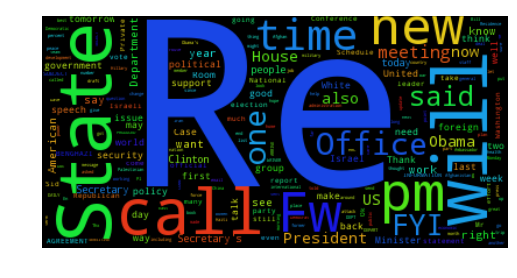

In [7]:
plt.imshow(wordcloud)
plt.axis("off")

### 1.2 Word cloud with preprocessing 

In [8]:
def filterStopWords(text):
    try:
        tokens = nltk.word_tokenize(text)
    except:
        nltk.download()
        tokens = nltk.word_tokenize(text)
    stopWords = stopwords.words('english')
    customWords = ['re','fwd','pm','am', 'also', 'and', 'fyi', 'tomorrow', 'today',
                   'well', '.', ',', '"', "'", '?', '&','/', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}', '@', '<', '>', '-', "n't"]
    stopWords += customWords
    filtered = list()
    for token in tokens:
        token = token.lower()
        if token not in stopWords:
            filtered.append(token)
    return filtered

#http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
def lemmAndStem(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    stemmed = [stemmer.stem(lema) for lema in lemmatized]
    return stemmed

def preprocess(text):
    filtered = filterStopWords(text)
    processed = lemmAndStem(filtered)
    return ' '.join(processed)

In [9]:
procText = preprocess(rawText)

(-0.5, 399.5, 199.5, -0.5)

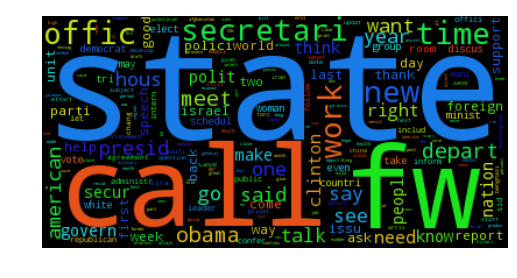

In [10]:
wordcloud = WordCloud().generate(procText)
plt.imshow(wordcloud)
plt.axis("off")

## 2. Sentiment Analysis

https://www.kaggle.com/operdeck/d/kaggle/hillary-clinton-emails/hillary-s-sentiment-about-countries

In [13]:
### Clean Data

In [14]:
import re
def clean_days_month(text):
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'September',
                 'November', 'December']
    hours = ['AM', 'PM']    
    return [word for word in text if word not in (week_days + months + hours)]

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def word_contains_number(word):
    return any(ch.isdigit() for ch in word)    
        
def clean_numbers(text):
    return [word for word in text if not is_number(word) and not word_contains_number(word) ]

def clean_symbol(text):
    tmp = [re.sub(r'[\w\.-]+@[\w\.-]+', '', word)for word in text]
    return [re.sub('[!@#$,:<>\().]', '', word) for word in tmp]

def clean_text(text):
    tmp = clean_symbol(text.split())
    tmp = filterStopWords(' '.join(clean_days_month(tmp)))
    return ' '.join(clean_numbers(tmp))


In [15]:
import pycountry
list_countries = list(pycountry.countries)
accumulator = {}
list_token = clean_text(rawText).split()
for country in list_countries:
    suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower().lower())
    accumulator[country.name] = suma

In [16]:
proba = pd.Series(accumulator, dtype='str')
proba

Afghanistan                              271
Albania                                   67
Algeria                                    3
American Samoa                             0
Andorra                                   12
Angola                                   135
Anguilla                                   2
Antarctica                                14
Antigua and Barbuda                        2
Argentina                                 21
Armenia                                    9
Aruba                                      1
Australia                                 18
Austria                                    2
Azerbaijan                                14
Bahamas                                    1
Bahrain                                    4
Bangladesh                                10
Barbados                                  11
Belarus                                    0
Belgium                                    4
Belize                                     0
Benin     

In [17]:
for i in list(pycountry.countries):
    print(i)

Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533')
Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan')
Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola')
Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660')
Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248')
Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania')
Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra')
Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784')
Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic')
Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia')
Country(alpha_2='AS', alpha_3='ASM', name='American Samoa', n

Clean data and tranform the strings to tokens

In [18]:
from nltk.sentiment.util import *
to_token = nltk.tokenize.RegexpTokenizer(r'\w+|\$')
#Cleaning Body of emails
tmp = []
for i in data.ExtractedBodyText.values:
    tmp.append(clean_text(i) )
data['token_Body'] = tmp
data['token_Body'] = data['token_Body'].apply(to_token.tokenize)
#Cleanning Subject of emails
tmp = []
for i in data.ExtractedSubject.values:
    tmp.append(clean_text(i) )
data['token_Subject'] = tmp
data['token_Subject'] = data['token_Subject'].apply(to_token.tokenize)

/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [19]:
def flatten(list1):
    return [ list1[x][y] for x in range(len(list1)) for y in range(len(list1[x]))]


In [34]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pycountry

def country_sentiment_row(data_df, df_sentiment_country):
    print(data_df.Id, end= ' ')
    token_data_df_ = data_df[['token_Body','token_Subject']]
    token_list_ = flatten(token_data_df_)
    
    list_countries = list(pycountry.countries)
    accumulator = {}
    list_token = flatten(token_data_df_)
    for country in list_countries:
        suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower().lower())
        accumulator[country.name] = suma
    

    sentiment_words = (SentimentIntensityAnalyzer().polarity_scores(data_df.ExtractedBodyText)['compound'])
    
    for contry in accumulator.keys():
        if accumulator[contry] > 0:
            df_sentiment_country.loc[contry]['Times'] = df_sentiment_country.loc[contry]['Times'] + accumulator[contry]
            df_sentiment_country.loc[contry]['Sentiment'] = df_sentiment_country.loc[contry]['Sentiment'] + sentiment_words
            

In [35]:
df_countries = pd.DataFrame(columns=['Times','Sentiment'])
for contry in list(pycountry.countries):
    df_countries.set_value(contry.name,['Times','Sentiment'],[0, 0])
df_countries.head()

,Times,Sentiment
Aruba,0.0,0.0
Afghanistan,0.0,0.0
Angola,0.0,0.0
Anguilla,0.0,0.0
Åland Islands,0.0,0.0


In [36]:
_ = data.apply(country_sentiment_row, args=(df_countries,),axis=1)

3 6 9 10 11 13 15 17 18 19 21 22 23 24 25 27 28 29 30 31 32 34 35 39 40 41 43 44 45 46 47 48 49 50 52 53 55 56 58 59 61 65 66 67 69 71 72 73 74 75 76 77 79 80 82 83 86 87 88 89 90 91 92 93 94 97 98 99 100 102 103 104 105 106 107 108 109 110 111 112 113 115 116 118 119 120 121 122 123 124 125 127 128 129 130 132 133 134 135 136 137 139 140 141 145 147 148 152 153 157 158 160 162 164 165 169 170 174 175 176 177 178 179 180 182 184 185 186 187 190 191 192 193 196 197 198 199 202 203 205 206 208 211 212 214 215 216 217 218 220 221 222 223 225 226 227 228 229 230 231 232 234 235 237 240 241 242 246 247 248 249 250 251 252 253 254 255 256 258 259 262 263 264 265 266 267 268 269 270 272 274 275 276 277 278 279 281 282 284 285 286 287 288 290 291 292 293 294 295 297 298 300 301 302 303 304 305 306 307 308 309 310 311 312 315 316 317 318 319 320 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 338 340 341 342 343 344 345 347 348 349 350 351 352 353 354 355 356 358 359 360 361 367 369

In [40]:
df_countries.sort_values(by='Times',ascending=False).head()

,Times,Sentiment
United States,1464.0,199.9026
Israel,435.0,27.5137
Afghanistan,291.0,35.7556
Haiti,288.0,40.0558
China,287.0,33.0619


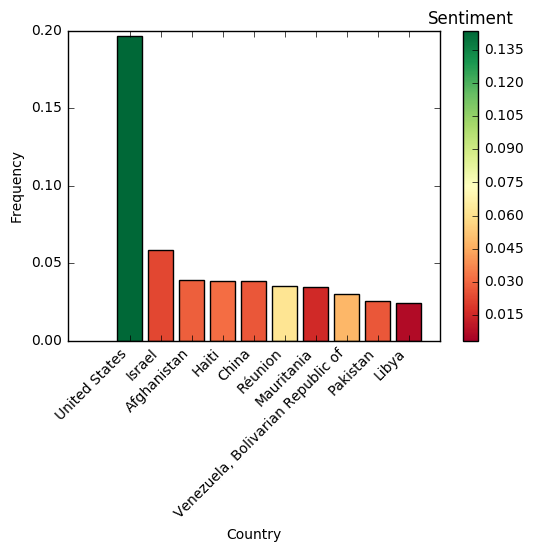

In [53]:
from matplotlib import cm
df_countries['Frequency'] = df_countries['Times']/sum(df_countries['Times'].values)
df_countries['FrequencySentiment'] = df_countries['Sentiment']/sum(df_countries['Sentiment'].values)

# Set up colors : red to green
df_set = df_countries.sort_values(by='Frequency',ascending=False)[:10]
y = np.array(df_set['FrequencySentiment'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(df_set.shape[0]), df_set['Frequency'], align='center', tick_label=df_set.index, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

## Bonus Conexion 

In [ ]:
dataset = data.copy()
dataset.dropna(subset=['MetadataFrom'], inplace=True)
dataset.dropna(subset=['MetadataTo'], inplace=True)

In [ ]:
dataset_ = dataset[['MetadataFrom', 'MetadataTo']]

In [ ]:
import networkx as nx
G=nx.Graph()
a = set(dataset_.MetadataFrom.values)
b = set(dataset_.MetadataTo.values)
c = set(list(a) + list(b))
G.add_nodes_from(list(c))
edges = [ (x, y) for x, y in dataset_.values.tolist()]
G.add_edges_from(edges)

try: # draw
    pos=nx.spring_layout(G,iterations=10)
    nx.draw(G,pos,node_size=0,alpha=0.4,edge_color='r',font_size=16)
    plt.figure(figsize=(20,20))    
    plt.show()
except: # matplotlib not available
    pass